# SkyMaps synthetic FasterRCNN model
A single image COCO dataset viewer. FasterRCNN note book to check how syntethic data is shown with generated COCO json file.

Synthetic images training dataset was in COCO format. 

#### Import required modules

In [1]:
# python modules.
import os
import sys
import json
from pathlib import Path
from math import trunc
import base64
from io import BytesIO

# data libraries.
import numpy as np

# pytorch modules
import torch
import torchvision
from torch.utils import data

# image modules.
import cv2
from PIL import Image

# tools
from pycocotools.coco import COCO

# display modules.
import IPython
from matplotlib import pyplot as plt



#### Mount google drive
Set the path for 'ThisstleSynImageFasterRCNNTrainer' module to find depending modules.
Folder structure

         root_dir
           |
           ---data
           |    |
           |    ---train
           |    |    |
           |    |    ---images
           |    |    |
           |    |    ---masks
           |    ---val
           |    |    |
           |    |    ---images
           |         |
           |    |    ---masks
           |    ---test
           |         |
           |         ---images
           |         |
           |         ---masks
           ---code
           |   |
           |   ---faster_rcnn_train_main.py
           |   ---faster_rcnn_utils.py
           |   ---faster_rcnn_config.py
           
Below code we have root_dir as VRKSynthesizeData
                   data     as UTSynData
                   code     as UTSynCode

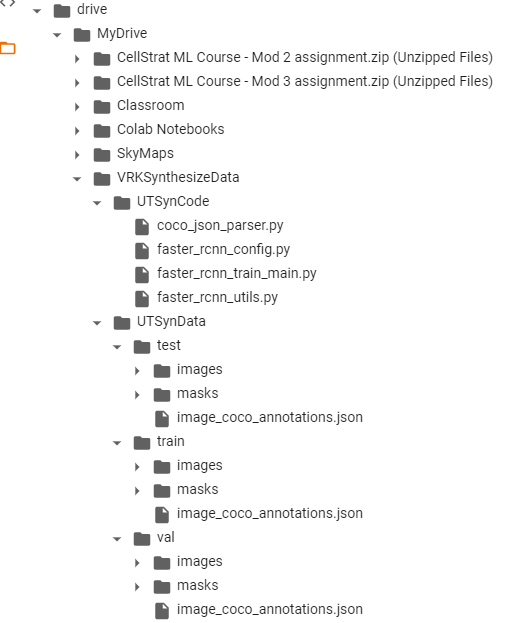

In [2]:
from google.colab import drive
drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/MyDrive/VRKSynthesizeData/UTSynCode')

Mounted at /content/drive


### Train part

#### Train Faster RCNN model.

In [3]:
cd '/content/drive/MyDrive/VRKSynthesizeData'

/content/drive/MyDrive/VRKSynthesizeData


In [4]:
from faster_rcnn_train_main import ThisstleSynImageFasterRCNNTrainer
syn_trainer = ThisstleSynImageFasterRCNNTrainer()
syn_trainer.train()

Torch version: 1.8.1+cu101
loading annotations into memory...
Done (t=1.33s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Epoch: 0/10
Epoch: 0, Loss: 1.406445026397705
Epoch: 1/10
Epoch: 1, Loss: 0.9098455309867859
Epoch: 2/10
Epoch: 2, Loss: 0.8090261816978455
Epoch: 3/10
Epoch: 3, Loss: 1.4157346487045288
Epoch: 4/10
Epoch: 4, Loss: 1.0594578981399536
Epoch: 5/10
Epoch: 5, Loss: 0.8580319881439209
Epoch: 6/10
Epoch: 6, Loss: 0.9903087615966797
Epoch: 7/10
Epoch: 7, Loss: 0.8762803673744202
Epoch: 8/10
Epoch: 8, Loss: 0.7137670516967773
Epoch: 9/10
Epoch: 9, Loss: 0.7603384256362915


### Test part

#### Test setup
1. Create dictonaries for detected crops and number of classes.
2. Get trained model
2. Crete test device.

In [5]:
# Create dictionaries for the detected crops (this is used only if plotting is needed)
class_dict = {1:'thistle'}
colour_dict = {1:(220, 0, 0)}
# Set number of classes
num_classes = 2  # 1 classes (thistle) + background

# load a model; pre-trained on COCO
my_model = syn_trainer.get_trained_model()

test_device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Device {test_device} is used for testing')

returning trained model
Device cuda is used for testing


#### Utility function to draw bounding box

In [6]:
def draw_text(img, text, font=cv2.FONT_HERSHEY_PLAIN, pos=(0, 0), font_scale=0.6, font_thickness=1,
              text_color=(0, 0, 0), text_color_bg=(0, 0, 0)):
    """ Function to pretty print label names above the bounding box
    """
    x, y = pos
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size
    cv2.rectangle(img, pos, (x + text_w, y + text_h), text_color_bg, -1)
    cv2.putText(img, text, (x, y + text_h + font_scale - 1), font, font_scale, text_color, font_thickness)

    return text_size

#### Get test synthetic image

In [7]:
from coco_json_parser import CocoDataset
instances_json_path = "/content/drive/MyDrive/VRKSynthesizeData/UTSynData/test/image_coco_annotations.json"
images_path = "/content/drive/MyDrive/VRKSynthesizeData/UTSynData/test/images"
coco_dataset = CocoDataset(instances_json_path, images_path)
coco_dataset.display_info()
coco_dataset.display_licenses()
coco_dataset.display_categories()

Dataset Info
  description: Skymaps test data
  url: https://skymaps.com
  version: 1.0
  year: 2021
  contributor: Omdena team
  date_created: 06/01/2021
Licenses
  url: https://skymaps.com/license
  id: 0
  name: skymaps
Categories
  super_category: weeds
    id 1: thistle



Image
  license: 0
  file_name: 00000003.jpg
  width: 512
  height: 512
  id: 3
Number of boxes in image are  3
  red: thistle
  green: thistle
  blue: thistle



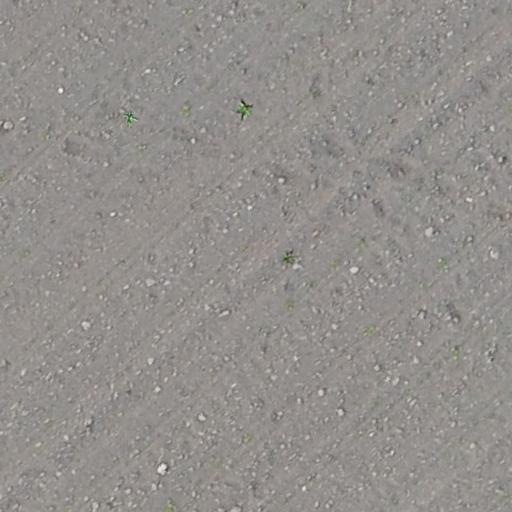

In [8]:
html = coco_dataset.display_image(3)
IPython.display.HTML(html)

In [9]:
# Choose a png file for test and visulation from test folder
test_images_path = '/content/drive/MyDrive/VRKSynthesizeData/UTSynData/test/images/'
image_file = '00000003.jpg'
pred_file = test_images_path + image_file
# Read the image using cv2
image = cv2.imread(pred_file, cv2.IMREAD_COLOR)

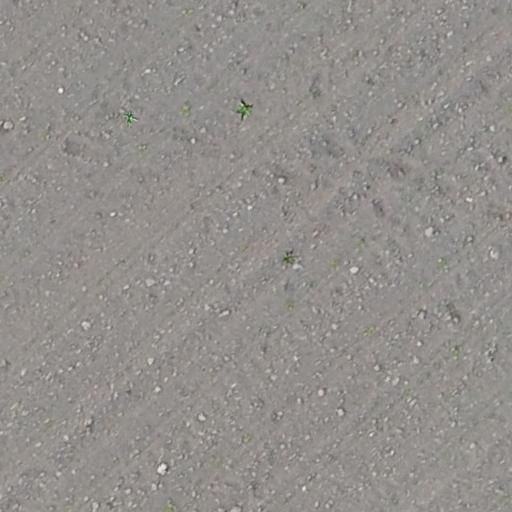

In [10]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [11]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
# Convert the image to torch tensor and send it to the processing device
image_torch = np.expand_dims(np.transpose(image, (2, 0, 1)), axis=0)
image_torch /= 255.0
image_torch = torch.tensor(image_torch).to(test_device)

#### Predict test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Visualised results from your custom model
lenght of predictions is  1
boxes size is  91


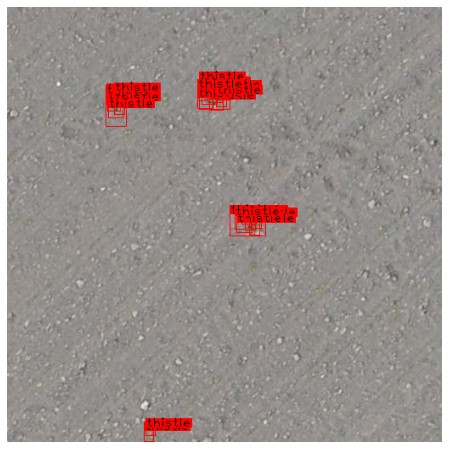

In [12]:
my_model.eval()
preds = my_model(image_torch)

print('Visualised results from your custom model')

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

print('lenght of predictions is ', len(preds))
for prediction in preds:
    # Get predictions from device and convert them to numpy
    boxes = prediction['boxes'].cpu().detach().numpy().astype(np.int32)
    labels = prediction['labels'].cpu().detach().numpy().astype(np.int32)
    scores = prediction['scores'].cpu().detach().numpy().astype(np.int32)

    print('boxes size is ', len(boxes))

    # Use NMS to get rid of overlapping predictions
    keep = torchvision.ops.nms(prediction['boxes'], prediction['scores'], 0.3).cpu().detach().numpy().astype(np.int32)

    # Plot all predicted bounding boxes onto a matplotlib plot with corresponding class names
    for i in range(len(boxes)):
        if i in keep:
            cv2.rectangle(image,
                          (boxes[i][0], boxes[i][1]),
                          (boxes[i][2], boxes[i][3]),
                          colour_dict[labels[i]], 1)

            draw_text(image,
                      class_dict[labels[i]],
                      font_scale=1,
                      pos=(boxes[i][0], boxes[i][1] - 10),
                      text_color_bg=colour_dict[labels[i]])

    ax.set_axis_off()
    ax.imshow(image)
    plt.show()